In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/utility/")
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/sizeNN_learnmodel_train/")
from Utility import data_collecter
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC(ours)",\
            "DKAC(ours)","DKN(ours)",\
                ]

In [3]:
def eval_err(suffix,env_name,method_index,layer_i):
    # method_index = 0
    method = Methods[method_index]
    root_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+suffix
    print(method)
    #sys.path.append("control/train/")
    if  method.endswith("KoopmanNonlinear"):
        import learn_DKN_SOC_sizeNN as lka
    elif method.endswith("KoopmanNonlinearA"):
        import learn_DKAC_SOC_sizeNN as lka
    elif method.endswith("KoopmanU"):
        import learn_DKUC_SOC_sizeNN as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name+"layer{}".format(layer_i)+"_") and file.endswith(".pth"):
            model_path = file  
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = layer_i
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim)
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim)
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim)  
    net.load_state_dict(state_dict)
    #device = torch.device("cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.cuda()
    net.double()
    Samples = 5000
    steps = 300
    random.seed(2022)
    np.random.seed(2022)
    times = 4 
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    min_loss_all = np.zeros((times,steps))
    with torch.no_grad():
        for i in range(times):
            test_data_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+"method{}{}.npy".format(env_name,i)
            if os.path.exists(test_data_path):
                test_data = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/{}{}.npy".format(env_name,i))
            else:
                test_data = Data_collect.collect_koopman_data(Samples,steps)
            np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+"method{}{}.npy".format(env_name,i),test_data)
            max_loss,mean_loss,min_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
            min_loss_all[i] = min_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    min_mean =  np.mean(min_loss_all,axis=0)
    min_std =  np.std(min_loss_all,axis=0)    
    np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+env_name+"_"+method+"layer1{}{}.npy".format(layer_i, steps),np.array([max_mean,max_std,mean_mean,mean_std,min_mean,min_std]))
    return max_mean,max_std,mean_mean,mean_std,min_mean,min_std

In [4]:
suffix = "compare_DKAC_sizeNN_30"
#suffix = "DKUC_SOC_sizeNN"
#suffix = "DKN_SOC_sizeNN"
#env_name = "DampingPendulum"

#env_name = "MountainCarContinuous-v0"
env_name = "CartPole-v1"
#env_name = "Pendulum-v1"
method_index = 5
method = Methods[method_index]
steps = 300
for i in range(5):
    eval_err(suffix,env_name,method_index=method_index,layer_i=i+1)

KoopmanNonlinearA


d:\learnsoftware\python\lib\site-packages\pygame\pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
KoopmanNonlinearA
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
KoopmanNonlinearA
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
KoopmanNonlinearA
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
KoopmanNonlinearA
torch.Size([301, 5000, 5])
torch.Size([24, 5000])
1
torch.Size([301, 5000, 5])
torch.Size([24, 5

<>:16: DeprecationWarning: invalid escape sequence \P


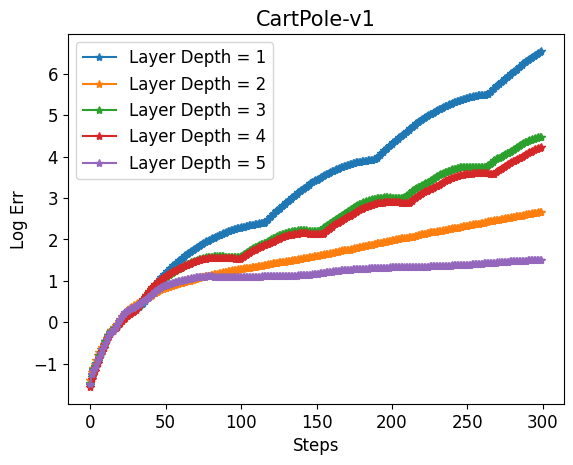

In [5]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size'   : 12}

plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
#env_name = "DampingPendulum"
# env_name = "CartPole-v1"
env_name = env_name
# env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "DoublePendulum"
title = env_name
compare = "max"
#compare = "mean"
#i = 2
""" file_path = "D:\毕业设计\中期\Python\DeepKoopmanWithControl-main\Prediction_Results\SizeNN/"+"MountainCarContinuous-v0_KoopmanNonlinearAlayer{}.npy".format(i+1)
data = np.load(file_path) """
#plt.plot(np.log10(data[0]),'*-',color = colors[i],label="Layer Depth of NNs = {}".format(i+1),linewidth=1.5)
for i in range(5):
    file_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+env_name+"_"+method+"layer1{}{}.npy".format(i+1, steps)
    data = np.load(file_path)
    plt.plot(np.log10(data[0]),'*-',color = colors[i],label="Layer Depth = {}".format(i+1),linewidth=1.5)
plt.legend()
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.title(title,fontsize=15)
plt.savefig("D:/毕业设计/论文/pictures/SOC_sizeNN/"+env_name+"_"+method+"_TESTmax_"+compare+"_new1.png",dpi=400)

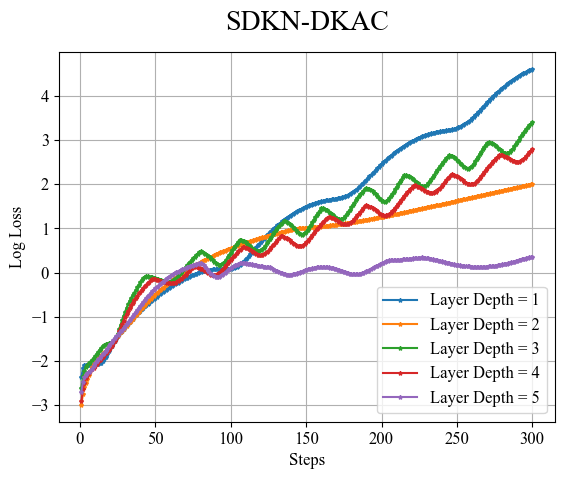

In [6]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size'   : 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 3

plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
#env_name = "DampingPendulum"
# env_name = "CartPole-v1"
env_name = env_name
# env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "DoublePendulum"
title = env_name
#compare = "max"
compare = "mean"
method = Methods[5]
steps = 300
T = []
for t in range(steps):
    T.append(t+1)
T = np.array(T)
#i = 2
""" file_path = "D:\毕业设计\中期\Python\DeepKoopmanWithControl-main\Prediction_Results\SizeNN/"+"MountainCarContinuous-v0_KoopmanNonlinearAlayer{}.npy".format(i+1)
data = np.load(file_path) """
#plt.plot(np.log10(data[0]),'*-',color = colors[i],label="Layer Depth of NNs = {}".format(i+1),linewidth=1.5)
for i in range(5):
    file_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+env_name+"_"+method+"layer1{}{}.npy".format(i+1, steps)
    data = np.load(file_path)
    plt.plot(T,np.log10(data[2]),'*-',color = colors[i],label="Layer Depth = {}".format(i+1))#,linewidth=1.5
    # 每隔10个数据点添加一个标记
    #marked_indices = np.arange(0, steps, 50)
    #plt.scatter(T[marked_indices], np.log10(data[2])[marked_indices], c=colors[i], marker='*')
plt.legend(loc = 'lower right')
plt.grid(True)
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Loss",fontsize=12)
plt.title("SDKN-DKAC",fontsize=20)
plt.savefig("D:/毕业设计/论文/pictures/SOC_sizeNN/SDKN-DKAC"+env_name+"_"+method+"_TESTmean_"+compare+"_new1.png",dpi=500)

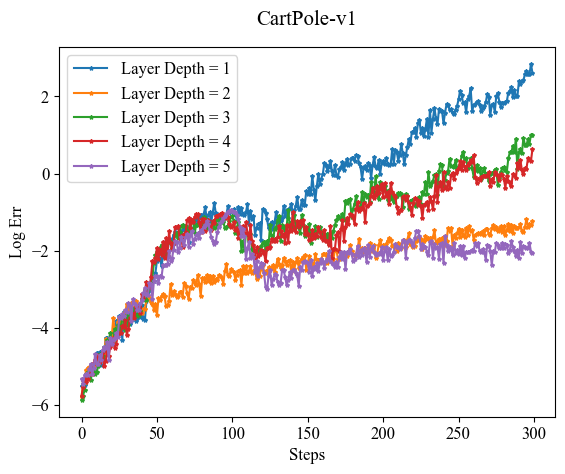

In [7]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size'   : 12}

plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
#env_name = "DampingPendulum"
# env_name = "CartPole-v1"
env_name = env_name
# env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "DoublePendulum"
title = env_name
#compare = "max"
compare = "min"
#i = 2
""" file_path = "D:\毕业设计\中期\Python\DeepKoopmanWithControl-main\Prediction_Results\SizeNN/"+"MountainCarContinuous-v0_KoopmanNonlinearAlayer{}.npy".format(i+1)
data = np.load(file_path) """
#plt.plot(np.log10(data[0]),'*-',color = colors[i],label="Layer Depth of NNs = {}".format(i+1),linewidth=1.5)
for i in range(5):
    file_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+env_name+"_"+method+"layer1{}{}.npy".format(i+1, steps)
    data = np.load(file_path)
    plt.plot(np.log10(data[4]),'*-',color = colors[i],label="Layer Depth = {}".format(i+1),linewidth=1.5)
plt.legend()
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.title(title,fontsize=15)
plt.savefig("D:/毕业设计/论文/pictures/SOC_sizeNN/"+env_name+"_"+method+"_TESTmin_"+compare+"_new1.png",dpi=400)

In [8]:
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# font = {'size'   : 12}
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# mpl.rcParams['font.family'] = ['Times New Roman']
# mpl.rcParams["axes.titlepad"] = 16
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.markersize'] = 3
# mpl.rcParams['lines.markeredgecolor'] = 'black'
# mpl.rcParams['lines.markeredgewidth'] = '0.1'
# mpl.rcParams['xtick.bottom'] = False
# mpl.rcParams['ytick.left'] = False
# #plt.rcParams['figure.figsize'] = 4,3 #窗口大小
# plt.rcParams['figure.subplot.left'] = 0.1
# plt.rcParams['figure.subplot.right'] = 0.9
# plt.rcParams['figure.subplot.bottom'] = 0.25
# plt.rcParams['figure.subplot.top'] = 0.75 #子视图大小占视图的比例
# plt.rcParams['savefig.dpi'] = 500 #图片像素

# Method = ["KoopmanU","KoopmanNonlinearA"]#,"KoopmanNonlinear"
# plt.rc('font', **font)
# # markers = ['*','+','*','+','*','+','*']
# env_name = "DampingPendulum"
# # env_name = "CartPole-v1"
# #env_name = env_name
# # env_name = "Pendulum-v1"
# # env_name = "Franka"
# # env_name = "DoublePendulum"
# title = env_name
# #compare = "max"
# compare = "mean"
# fig, ax = plt.subplots(nrows=1, ncols=len(np.array(Method)), figsize=(4*len(np.array(Method)), 4))
# for p in range(len(np.array(Method))):
#     method = Method[p]
#     for i in range(5):
#         file_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+env_name+"_"+method+"layer1{}{}.npy".format(i+1, steps)
#         data = np.load(file_path)
#         ax[p].plot(np.log10(data[2]),'-',color = colors[i],label="Layer Depth = {}".format(i+1))#,linewidth=1.5
#     ax[p].set_title(method, x=0.5, y=-0.40)
#     ax[p].grid(True)
# plt.legend(bbox_to_anchor=(-1.28, -0.25),loc='upper center', ncol=5)
# plt.grid(True)
# # plt.grid(linestyle='-.')
# plt.xlabel("Steps",fontsize=12)
# plt.ylabel("Log Loss",fontsize=12)
# plt.title(title,fontsize=15)
# plt.savefig("D:/毕业设计/论文/pictures/SOC_sizeNN/"+env_name+"_"+method+"_allmean_"+compare+".png",dpi=500)